# TSLA Stock Price Visualization

This notebook visualizes Tesla (TSLA) stock price movements using candlestick charts showing:
- **Candle bodies**: Open and close prices
- **Wicks**: High and low prices
- **Volume**: Trading volume as a separate line/bar chart

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# For candlestick charts
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Figure size
plt.rcParams['figure.figsize'] = (16, 10)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load Data

In [2]:
# Load sanitized TSLA stock data
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data' / 'sanitized'

df_tsla = pd.read_csv(DATA_DIR / 'TSLA_sanitized.csv')
df_tsla['Date'] = pd.to_datetime(df_tsla['Date'])

# Sort by date
df_tsla = df_tsla.sort_values('Date').reset_index(drop=True)

print(f"Loaded {len(df_tsla):,} trading days")
print(f"Date range: {df_tsla['Date'].min().date()} to {df_tsla['Date'].max().date()}")
print(f"\nPrice range: ${df_tsla['Low'].min():.2f} - ${df_tsla['High'].max():.2f}")

# Show sample
df_tsla.head(10)

Loaded 3,680 trading days
Date range: 2010-06-29 to 2025-02-12

Price range: $1.00 - $488.54


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
5,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
6,2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000
7,2010-07-09,1.172000,1.193333,1.103333,1.160000,1.160000,60759000
8,2010-07-12,1.196667,1.204667,1.133333,1.136667,1.136667,33037500
9,2010-07-13,1.159333,1.242667,1.126667,1.209333,1.209333,40201500


## Helper Function: Candlestick Chart

In [3]:
def plot_candlestick(df, start_date=None, end_date=None, title="TSLA Stock Price", figsize=(16, 10)):
    """
    Plot candlestick chart with volume
    
    Parameters:
    - df: DataFrame with columns Date, Open, High, Low, Close, Volume
    - start_date: Optional start date for filtering
    - end_date: Optional end date for filtering
    - title: Chart title
    - figsize: Figure size tuple
    """
    # Filter data by date range if specified
    df_plot = df.copy()
    if start_date:
        df_plot = df_plot[df_plot['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_plot = df_plot[df_plot['Date'] <= pd.to_datetime(end_date)]
    
    if len(df_plot) == 0:
        print("No data in specified date range")
        return
    
    # Create figure with 2 subplots (price and volume)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, 
                                     gridspec_kw={'height_ratios': [3, 1]},
                                     sharex=True)
    
    # Convert dates to matplotlib format
    dates = mdates.date2num(df_plot['Date'])
    
    # Calculate candle width (80% of the gap between dates)
    if len(dates) > 1:
        width = 0.6 * (dates[1] - dates[0])
    else:
        width = 0.6
    
    # Plot candlesticks
    for idx, row in df_plot.iterrows():
        date = mdates.date2num(row['Date'])
        open_price = row['Open']
        close_price = row['Close']
        high_price = row['High']
        low_price = row['Low']
        
        # Determine color (green if close > open, red otherwise)
        if close_price >= open_price:
            color = '#26A69A'  # Green (bullish)
            body_height = close_price - open_price
            body_bottom = open_price
        else:
            color = '#EF5350'  # Red (bearish)
            body_height = open_price - close_price
            body_bottom = close_price
        
        # Draw the wicks (high-low line)
        ax1.plot([date, date], [low_price, high_price], 
                color=color, linewidth=1, alpha=0.8)
        
        # Draw the body (open-close rectangle)
        rect = Rectangle((date - width/2, body_bottom), width, body_height,
                        facecolor=color, edgecolor=color, alpha=0.8)
        ax1.add_patch(rect)
    
    # Format price chart
    ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
    ax1.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Plot volume
    colors = ['#26A69A' if df_plot.iloc[i]['Close'] >= df_plot.iloc[i]['Open'] 
              else '#EF5350' for i in range(len(df_plot))]
    ax2.bar(dates, df_plot['Volume'], width=width, color=colors, alpha=0.6)
    ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))
    
    # Format x-axis dates
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#26A69A', label='Bullish (Close ≥ Open)'),
                      Patch(facecolor='#EF5350', label='Bearish (Close < Open)')]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nPeriod: {df_plot['Date'].min().date()} to {df_plot['Date'].max().date()}")
    print(f"Trading days: {len(df_plot):,}")
    print(f"Price range: ${df_plot['Low'].min():.2f} - ${df_plot['High'].max():.2f}")
    print(f"Starting price: ${df_plot.iloc[0]['Open']:.2f}")
    print(f"Ending price: ${df_plot.iloc[-1]['Close']:.2f}")
    change = ((df_plot.iloc[-1]['Close'] - df_plot.iloc[0]['Open']) / df_plot.iloc[0]['Open']) * 100
    print(f"Total change: {change:+.2f}%")
    print(f"Avg daily volume: {df_plot['Volume'].mean()/1e6:.1f}M shares")

print("Candlestick function defined!")

Candlestick function defined!


## Full Historical View (All Data)

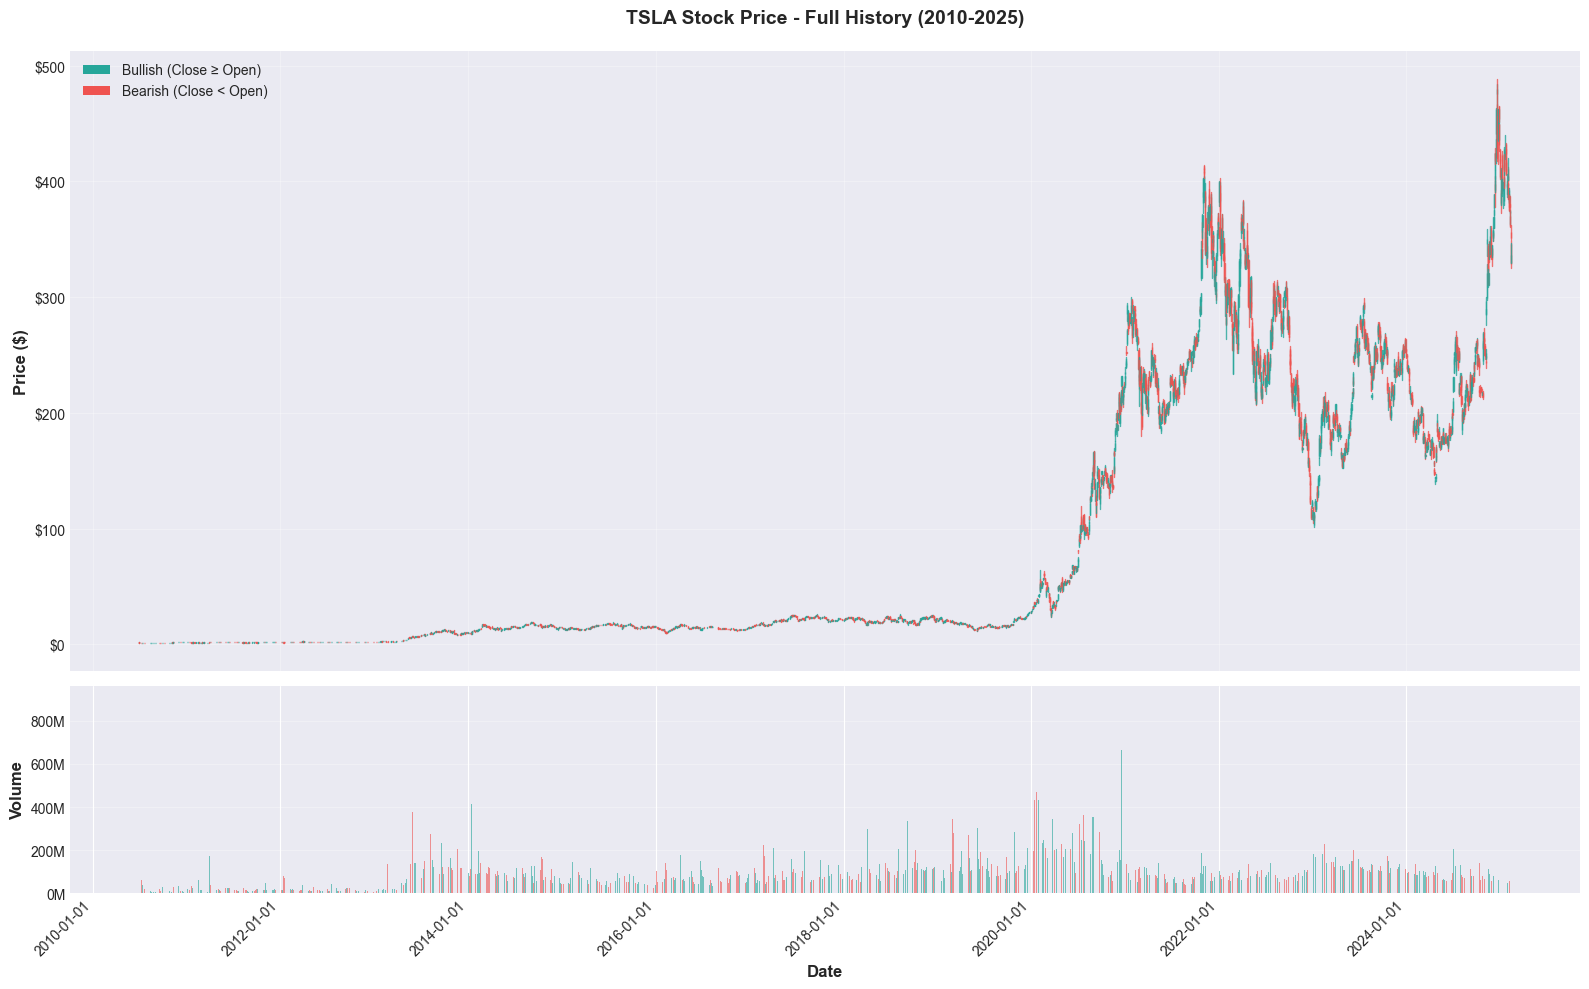


Period: 2010-06-29 to 2025-02-12
Trading days: 3,680
Price range: $1.00 - $488.54
Starting price: $1.27
Ending price: $336.51
Total change: +26466.57%
Avg daily volume: 96.5M shares


In [4]:
# Plot all historical data
plot_candlestick(df_tsla, title="TSLA Stock Price - Full History (2010-2025)")

## Recent 1 Year View

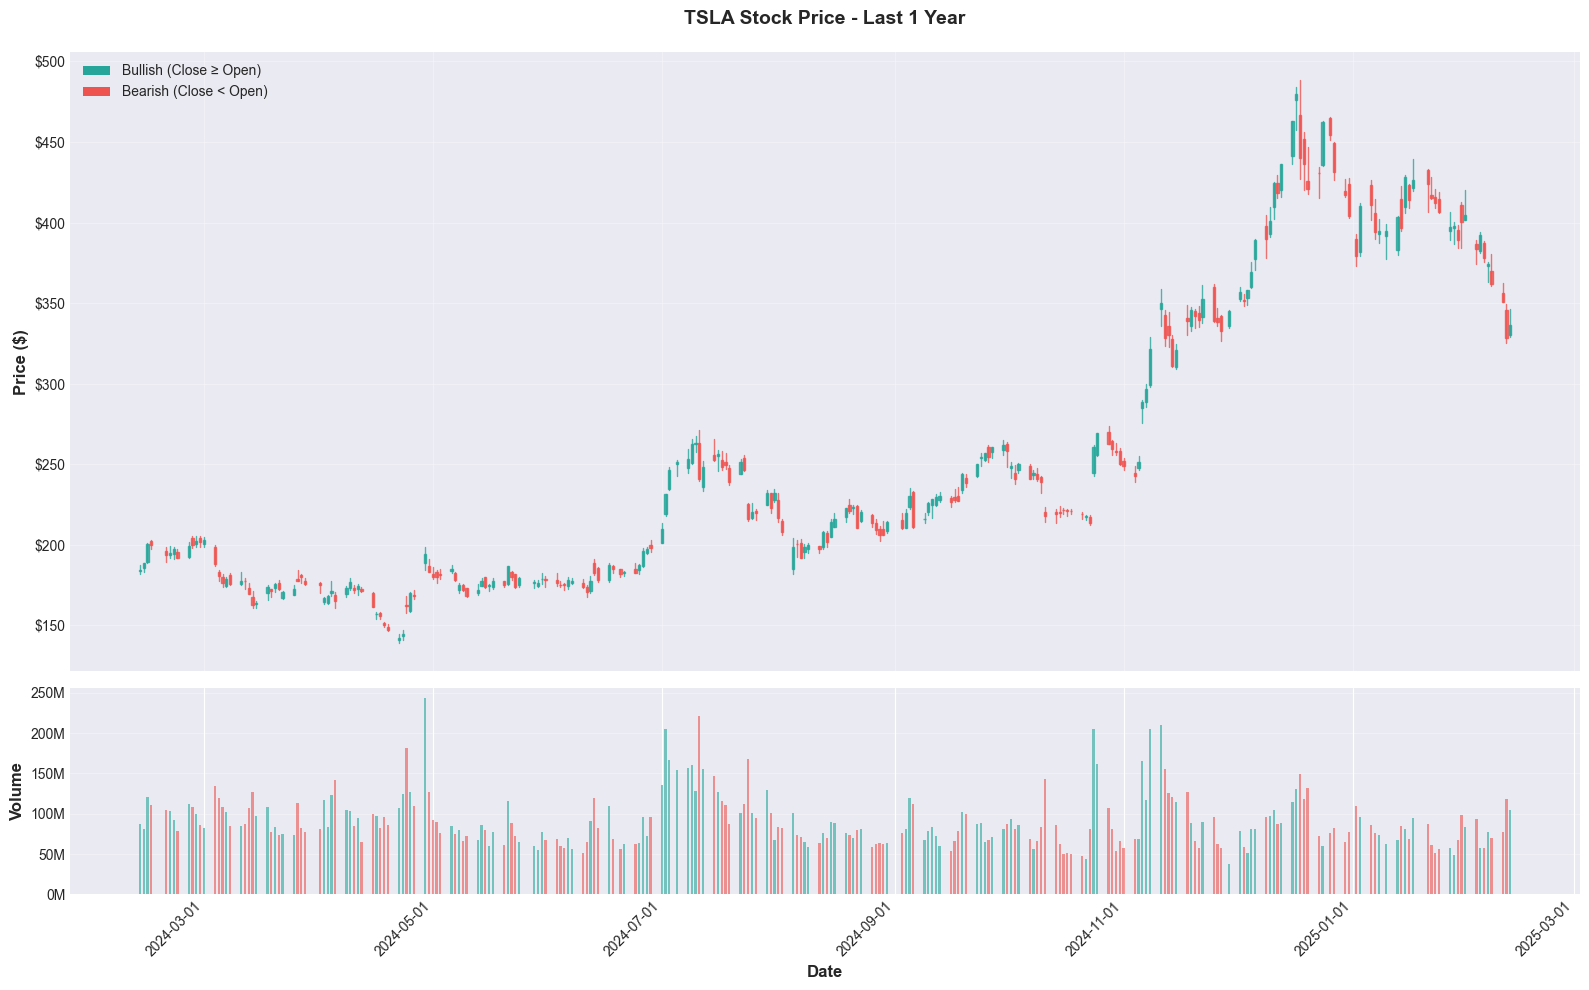


Period: 2024-02-13 to 2025-02-12
Trading days: 251
Price range: $138.80 - $488.54
Starting price: $183.99
Ending price: $336.51
Total change: +82.90%
Avg daily volume: 91.2M shares


In [5]:
# Last 1 year
end_date = df_tsla['Date'].max()
start_date = end_date - timedelta(days=365)

plot_candlestick(df_tsla, 
                start_date=start_date, 
                end_date=end_date,
                title="TSLA Stock Price - Last 1 Year")

## Recent 6 Months View

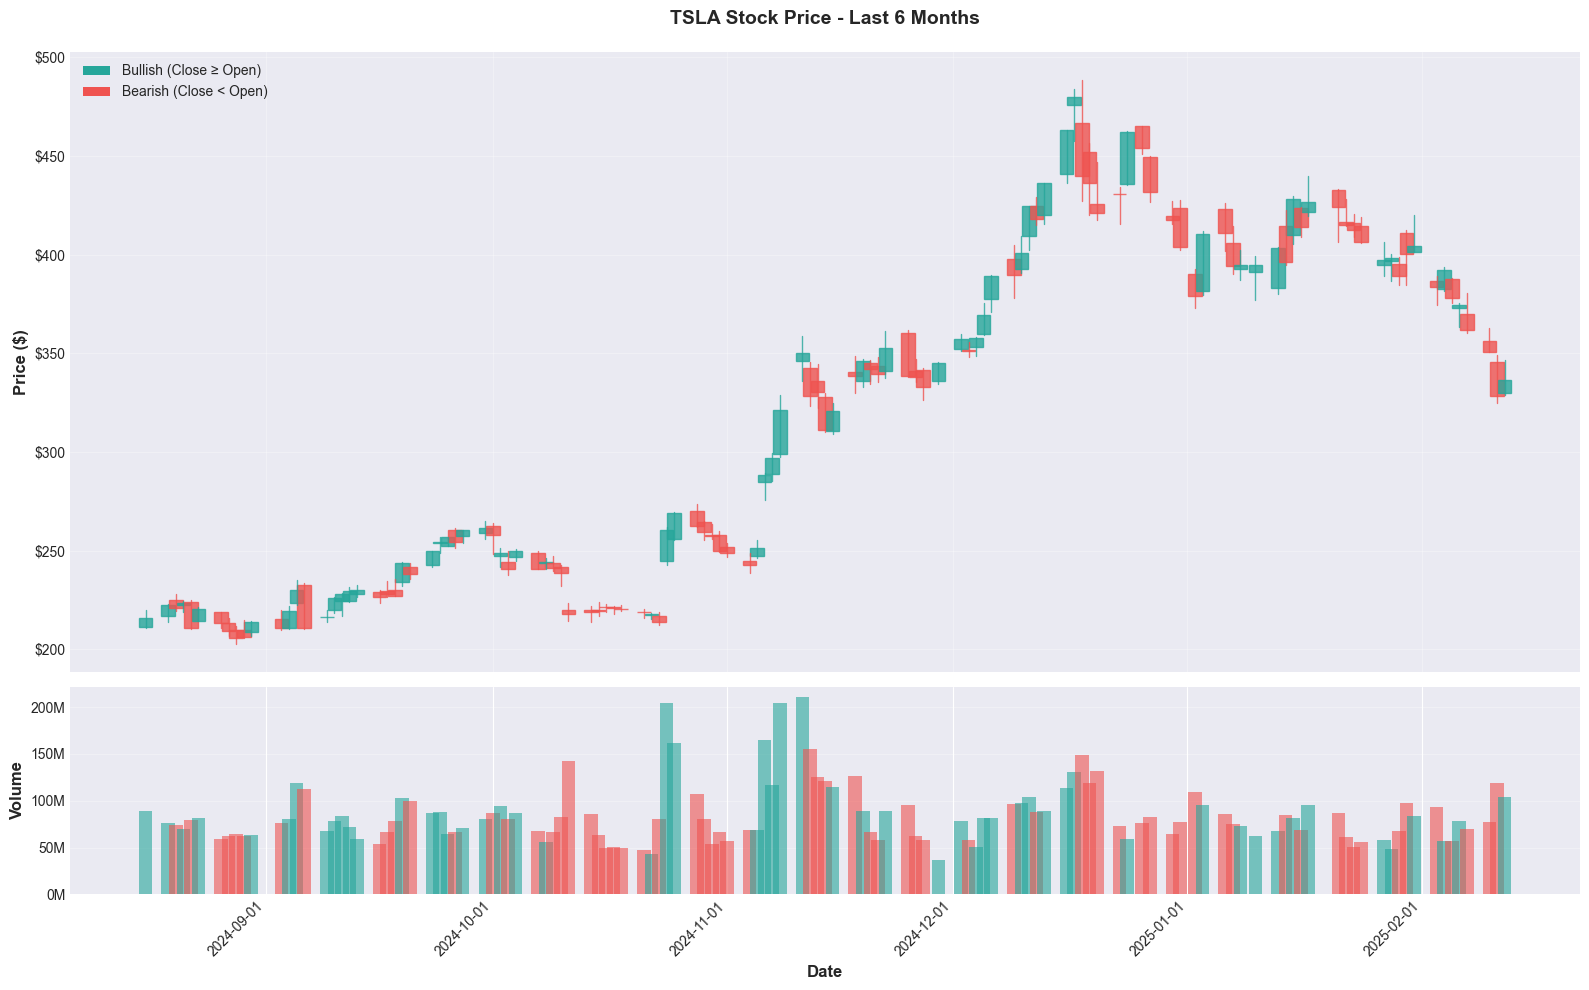


Period: 2024-08-16 to 2025-02-12
Trading days: 123
Price range: $202.59 - $488.54
Starting price: $211.15
Ending price: $336.51
Total change: +59.37%
Avg daily volume: 85.1M shares


In [6]:
# Last 6 months
end_date = df_tsla['Date'].max()
start_date = end_date - timedelta(days=180)

plot_candlestick(df_tsla, 
                start_date=start_date, 
                end_date=end_date,
                title="TSLA Stock Price - Last 6 Months")

## Recent 3 Months View

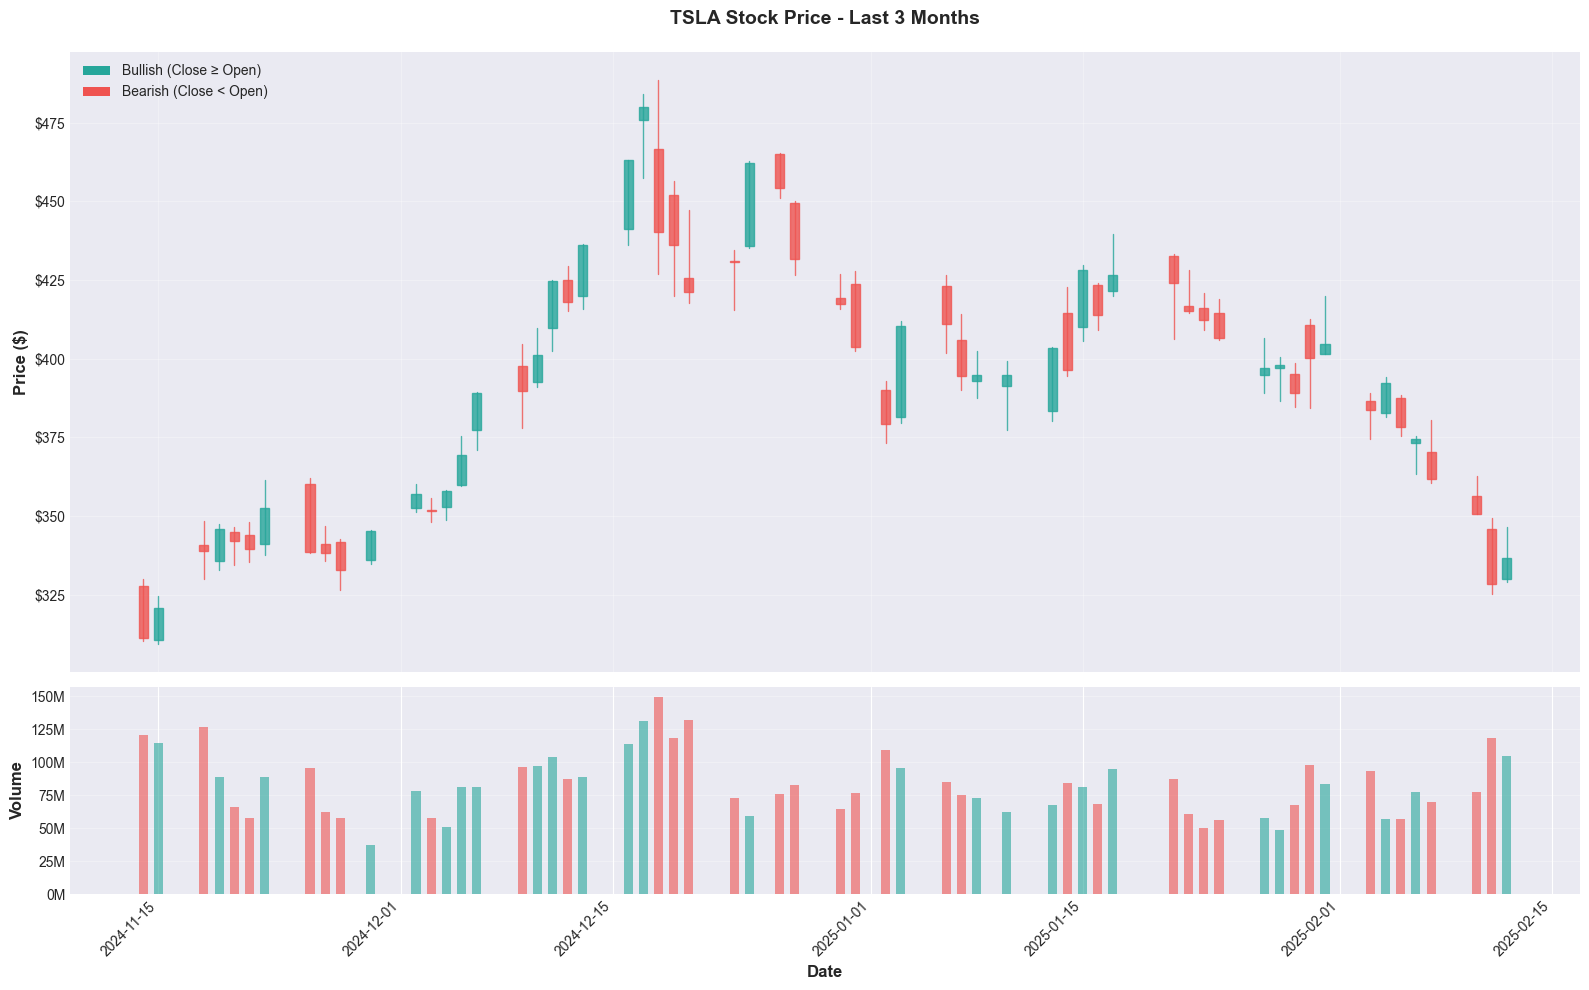


Period: 2024-11-14 to 2025-02-12
Trading days: 60
Price range: $309.22 - $488.54
Starting price: $327.69
Ending price: $336.51
Total change: +2.69%
Avg daily volume: 83.1M shares


In [7]:
# Last 3 months
end_date = df_tsla['Date'].max()
start_date = end_date - timedelta(days=90)

plot_candlestick(df_tsla, 
                start_date=start_date, 
                end_date=end_date,
                title="TSLA Stock Price - Last 3 Months")

## Recent 1 Month View

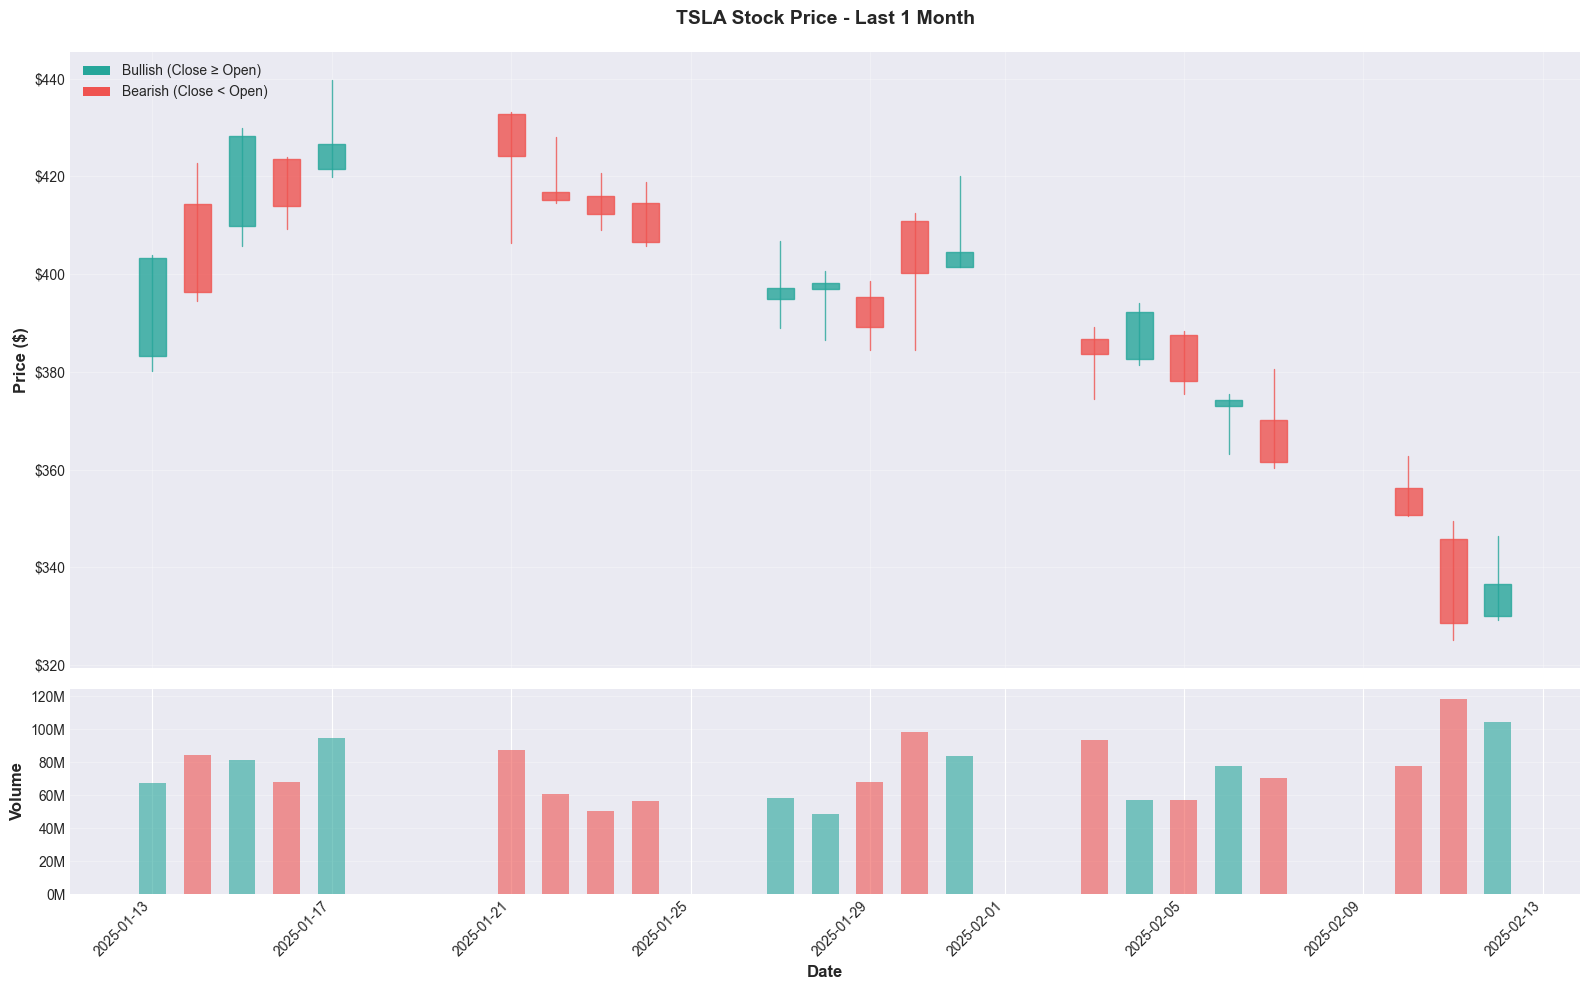


Period: 2025-01-13 to 2025-02-12
Trading days: 22
Price range: $325.10 - $439.74
Starting price: $383.21
Ending price: $336.51
Total change: -12.19%
Avg daily volume: 75.7M shares


In [8]:
# Last 1 month
end_date = df_tsla['Date'].max()
start_date = end_date - timedelta(days=30)

plot_candlestick(df_tsla, 
                start_date=start_date, 
                end_date=end_date,
                title="TSLA Stock Price - Last 1 Month")

## Custom Date Range

Adjust the dates below to visualize any specific period.

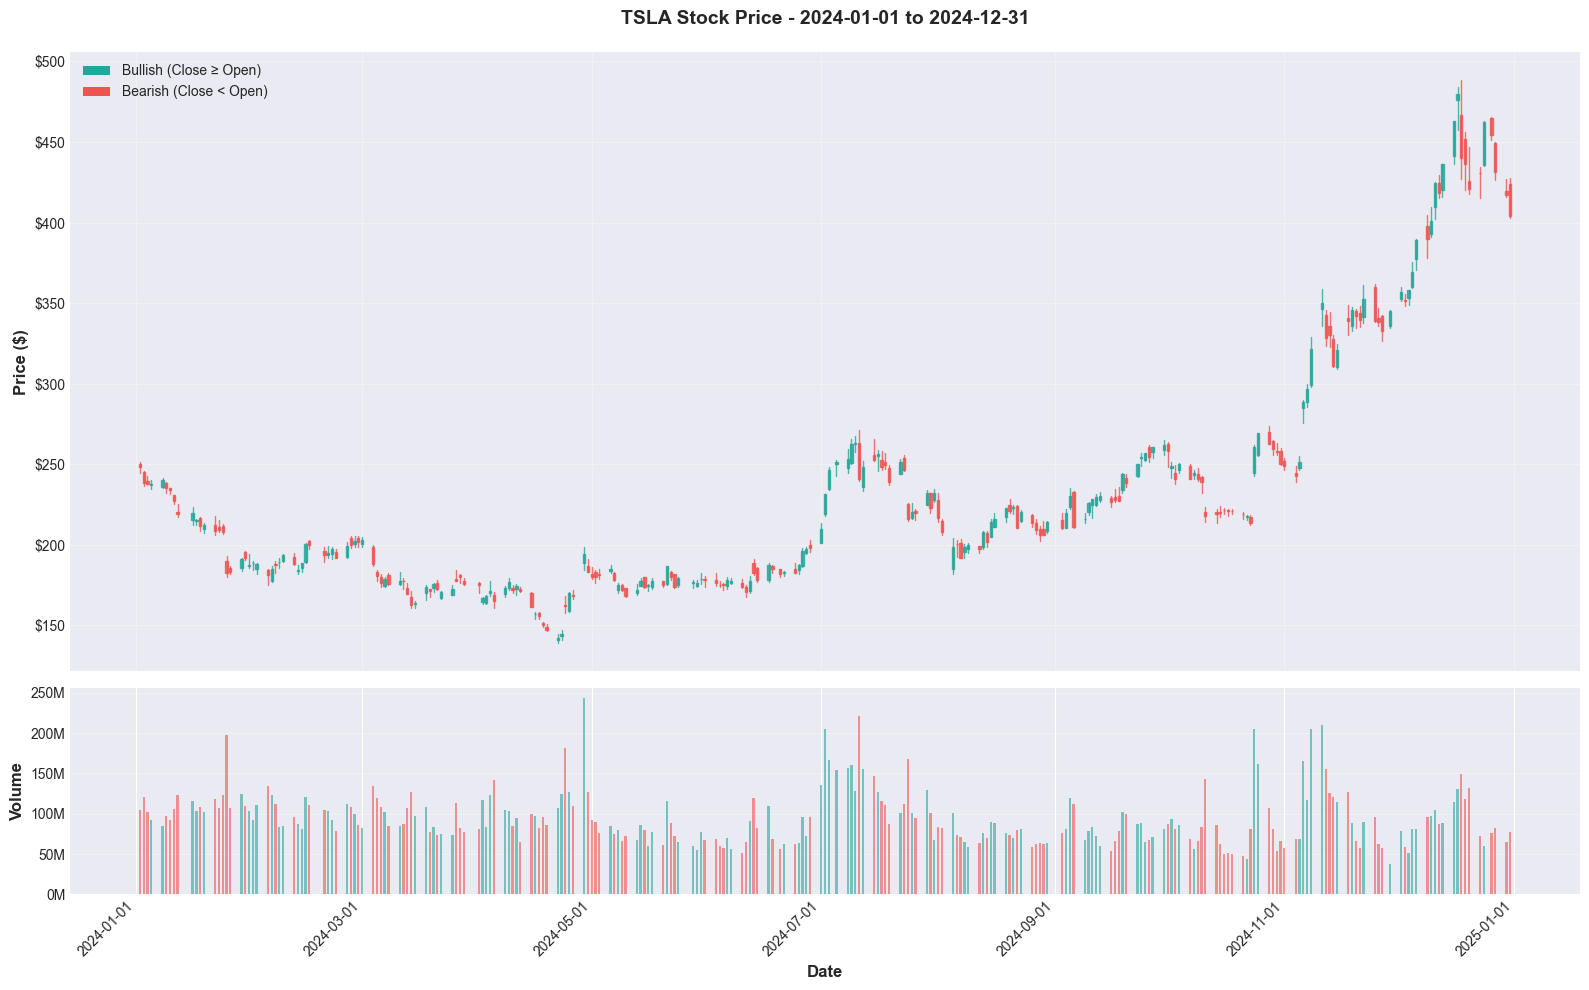


Period: 2024-01-02 to 2024-12-31
Trading days: 252
Price range: $138.80 - $488.54
Starting price: $250.08
Ending price: $403.84
Total change: +61.48%
Avg daily volume: 94.8M shares


In [9]:
# Custom date range - modify these dates as needed
custom_start = '2024-01-01'
custom_end = '2024-12-31'

plot_candlestick(df_tsla, 
                start_date=custom_start, 
                end_date=custom_end,
                title=f"TSLA Stock Price - {custom_start} to {custom_end}")

## Year-by-Year Comparison

Available years: [np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]

Generating candlestick charts for each year...



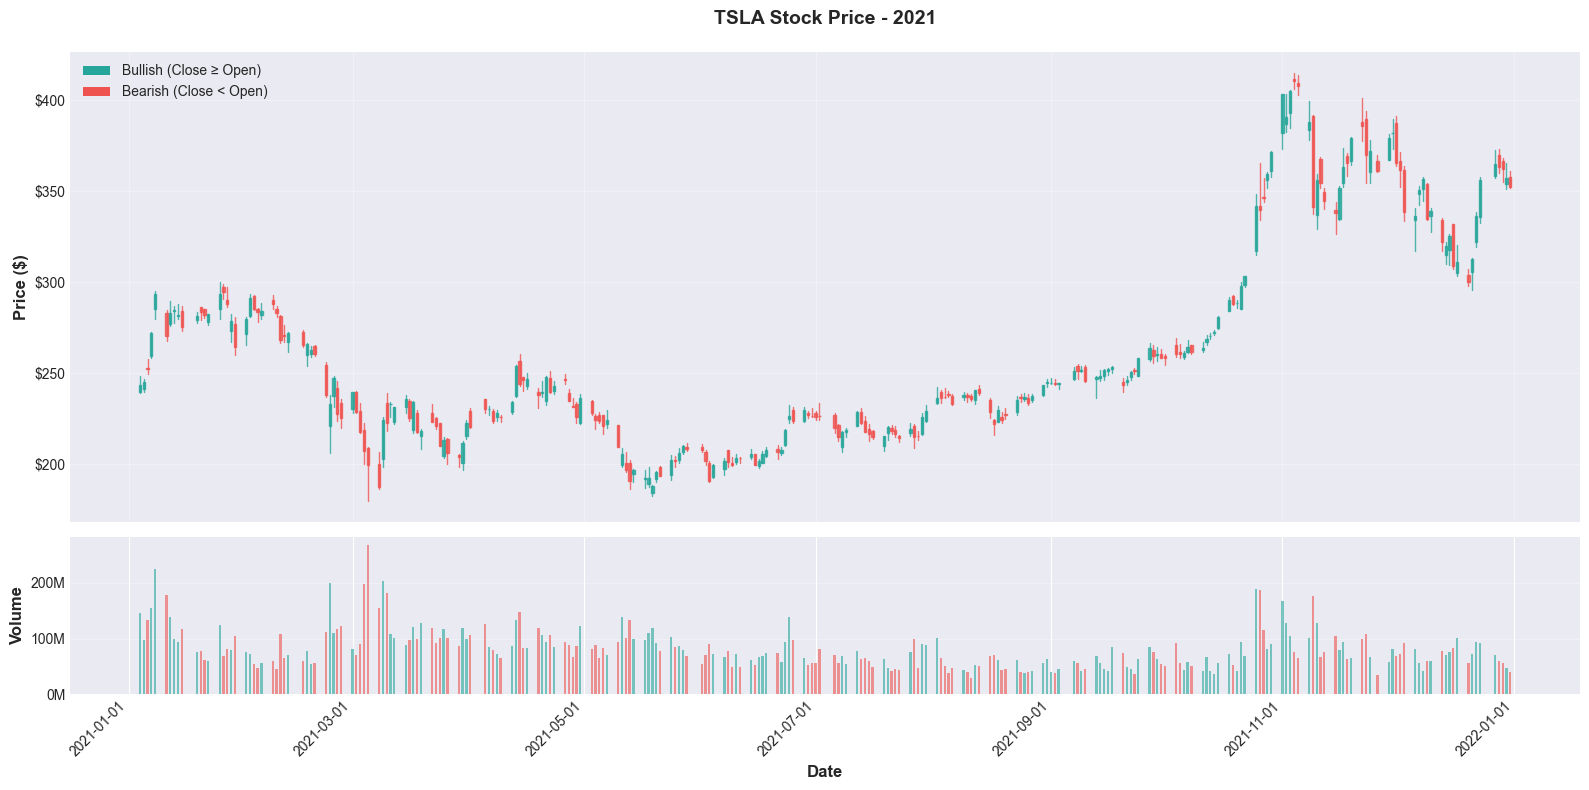


Period: 2021-01-04 to 2021-12-31
Trading days: 252
Price range: $179.83 - $414.50
Starting price: $239.82
Ending price: $352.26
Total change: +46.89%
Avg daily volume: 82.2M shares


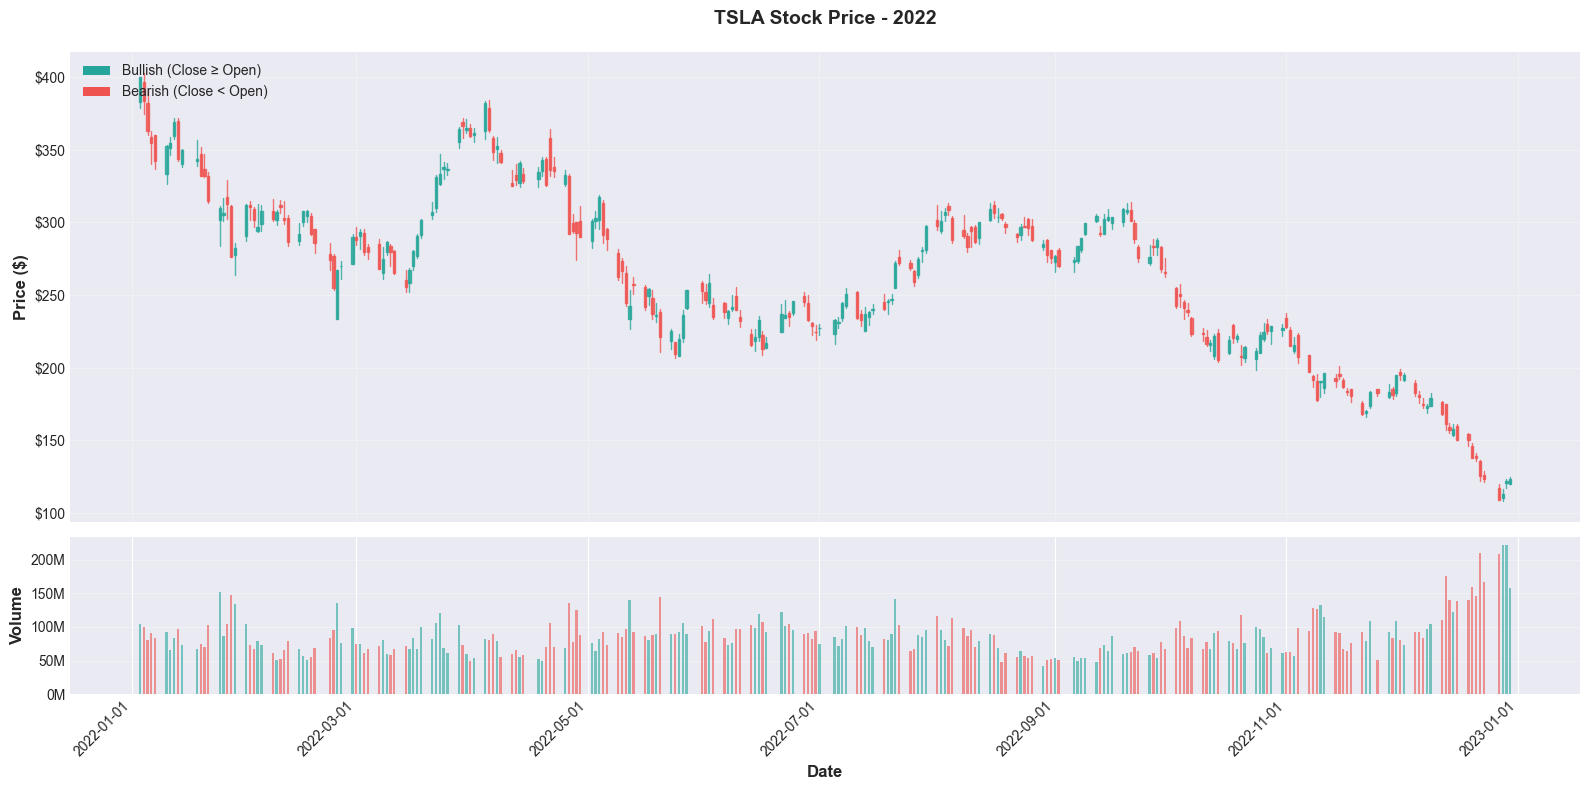


Period: 2022-01-03 to 2022-12-30
Trading days: 251
Price range: $108.24 - $402.67
Starting price: $382.58
Ending price: $123.18
Total change: -67.80%
Avg daily volume: 86.9M shares


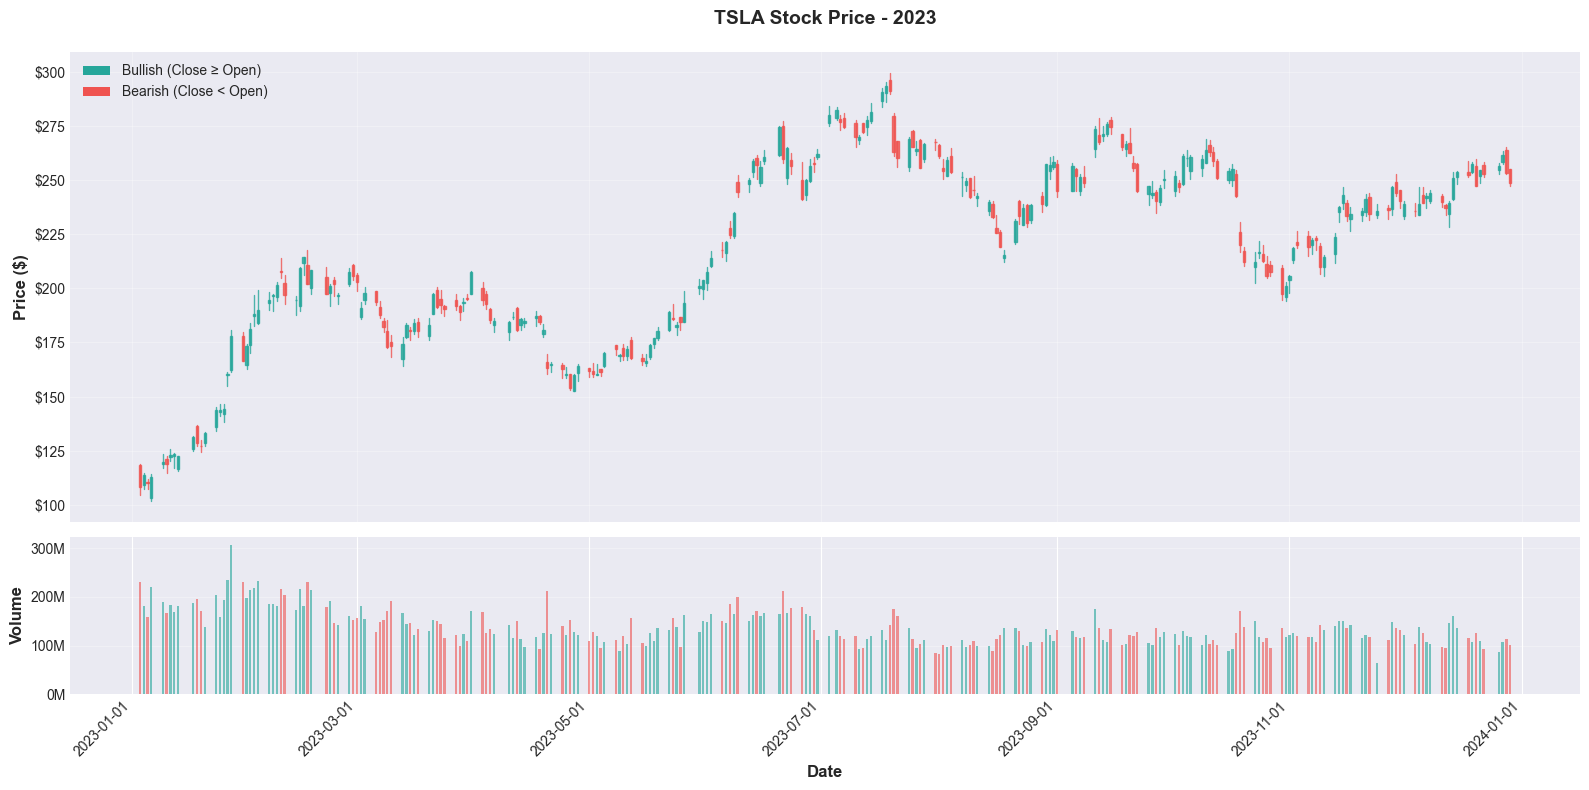


Period: 2023-01-03 to 2023-12-29
Trading days: 250
Price range: $101.81 - $299.29
Starting price: $118.47
Ending price: $248.48
Total change: +109.74%
Avg daily volume: 137.3M shares


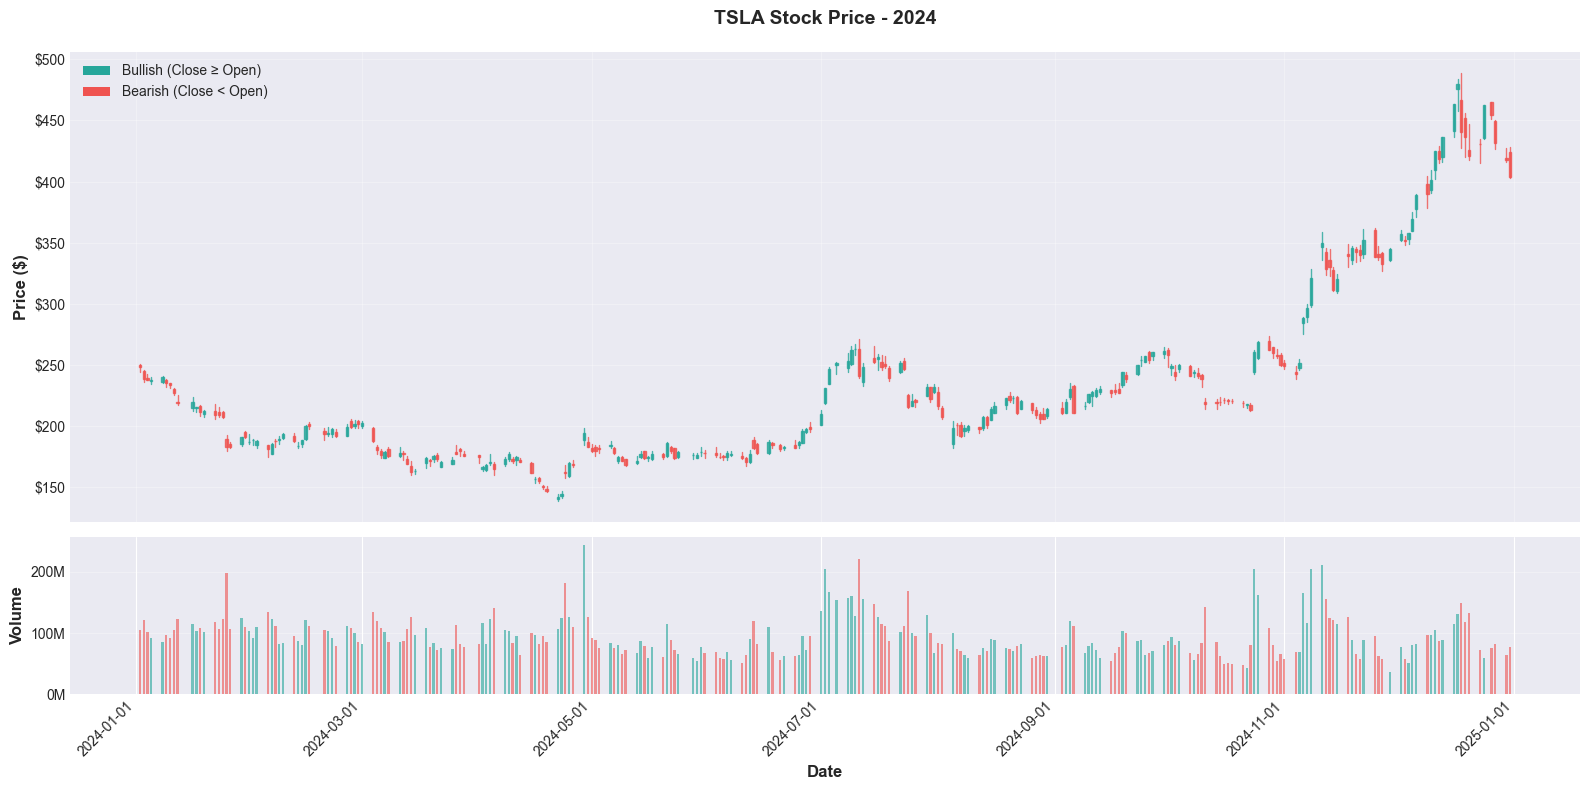


Period: 2024-01-02 to 2024-12-31
Trading days: 252
Price range: $138.80 - $488.54
Starting price: $250.08
Ending price: $403.84
Total change: +61.48%
Avg daily volume: 94.8M shares


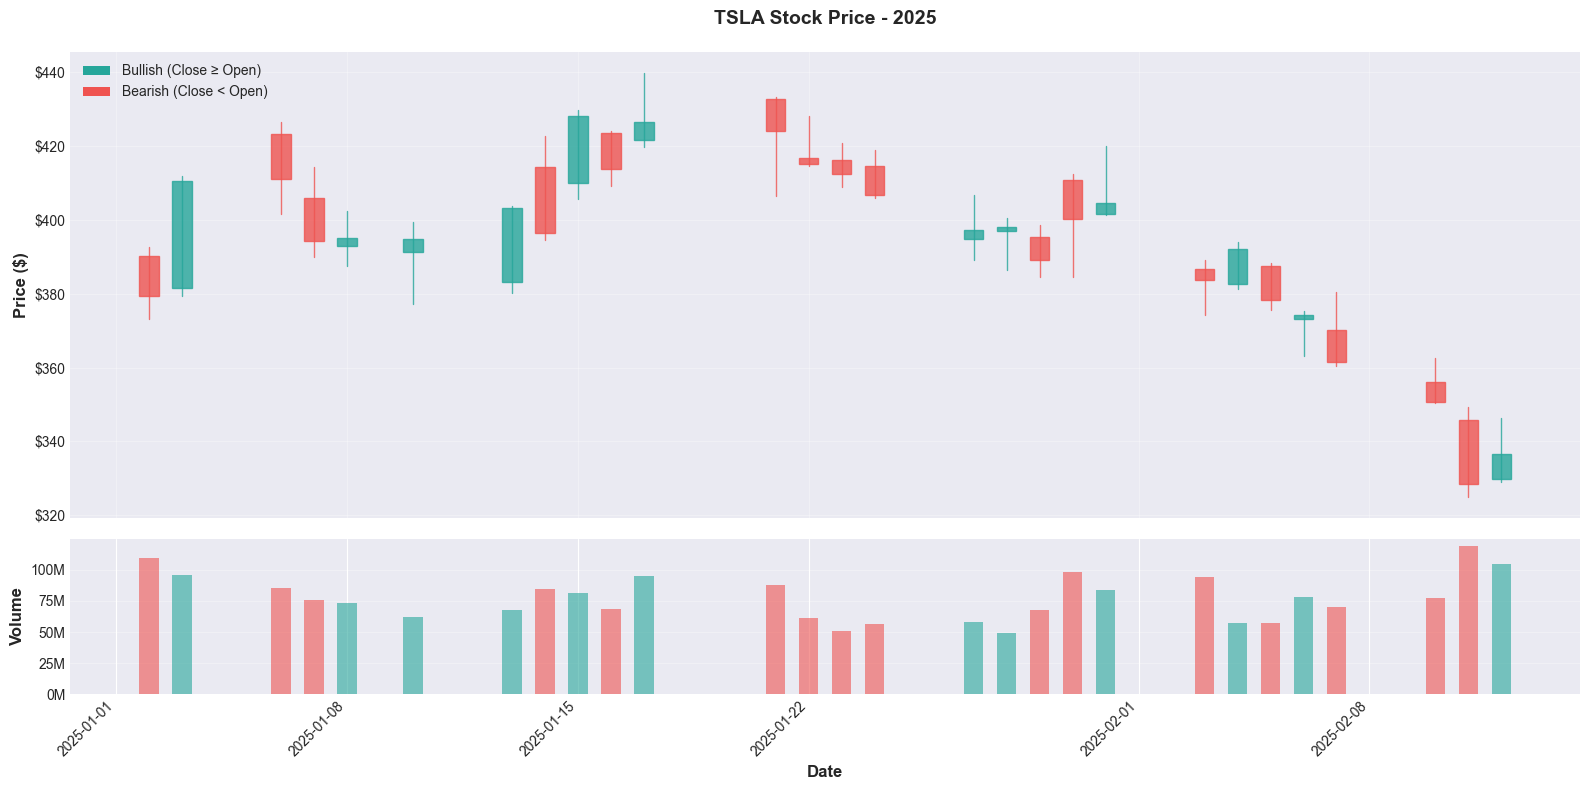


Period: 2025-01-02 to 2025-02-12
Trading days: 28
Price range: $325.10 - $439.74
Starting price: $390.10
Ending price: $336.51
Total change: -13.74%
Avg daily volume: 77.4M shares


In [10]:
# Plot each year separately for comparison
df_tsla['Year'] = df_tsla['Date'].dt.year
years = sorted(df_tsla['Year'].unique())

print(f"Available years: {years}")
print(f"\nGenerating candlestick charts for each year...\n")

for year in years[-5:]:  # Last 5 years
    year_data = df_tsla[df_tsla['Year'] == year]
    if len(year_data) > 0:
        plot_candlestick(year_data, 
                        title=f"TSLA Stock Price - {year}",
                        figsize=(16, 8))

## Price Statistics by Year

In [11]:
# Calculate statistics by year
yearly_stats = df_tsla.groupby('Year').agg({
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min',
    'Volume': 'mean'
}).round(2)

# Calculate yearly change
yearly_stats['Change'] = yearly_stats['Close'] - yearly_stats['Open']
yearly_stats['Change %'] = ((yearly_stats['Close'] - yearly_stats['Open']) / yearly_stats['Open'] * 100).round(2)
yearly_stats['Range'] = yearly_stats['High'] - yearly_stats['Low']
yearly_stats['Avg Volume (M)'] = (yearly_stats['Volume'] / 1e6).round(1)

# Rename columns for clarity
yearly_stats = yearly_stats.rename(columns={
    'Open': 'Open Price',
    'Close': 'Close Price',
    'High': 'Year High',
    'Low': 'Year Low'
})

print("TSLA Stock - Yearly Statistics")
print("=" * 120)
yearly_stats[['Open Price', 'Close Price', 'Change', 'Change %', 'Year High', 'Year Low', 'Range', 'Avg Volume (M)']]

TSLA Stock - Yearly Statistics


,Open Price,Close Price,Change,Change %,Year High,Year Low,Range,Avg Volume (M)
Year,,,,,,,,
2010,1.27,1.78,0.51,40.16,2.43,1.00,1.43,23.7
2011,1.79,1.90,0.11,6.15,2.33,1.41,0.92,19.4
2012,1.93,2.26,0.33,17.10,2.66,1.51,1.15,18.4
2013,2.33,10.03,7.70,330.47,12.97,2.14,10.83,126.1
2014,9.99,14.83,4.84,48.45,19.43,9.11,10.32,103.7
2015,14.86,16.00,1.14,7.67,19.11,12.09,7.02,64.8
2016,15.38,14.25,-1.13,-7.35,17.96,9.40,8.56,69.2
2017,14.32,20.76,6.44,44.97,25.97,14.06,11.91,95.0
2018,20.80,22.19,1.39,6.68,25.83,16.31,9.52,129.2


## Trading Days Analysis

In [12]:
# Analyze bullish vs bearish days
df_tsla['Daily_Change'] = df_tsla['Close'] - df_tsla['Open']
df_tsla['Daily_Change_Pct'] = (df_tsla['Daily_Change'] / df_tsla['Open'] * 100).round(2)
df_tsla['Day_Type'] = df_tsla['Daily_Change'].apply(lambda x: 'Bullish' if x >= 0 else 'Bearish')

print("Trading Days Analysis")
print("=" * 80)
print(f"\nTotal trading days: {len(df_tsla):,}")
print(f"\nDay type distribution:")
print(df_tsla['Day_Type'].value_counts())
print(f"\nPercentage:")
print((df_tsla['Day_Type'].value_counts(normalize=True) * 100).round(2))

print(f"\n\nDaily Change Statistics:")
print(f"Average daily change: ${df_tsla['Daily_Change'].mean():.2f} ({df_tsla['Daily_Change_Pct'].mean():.2f}%)")
print(f"Median daily change: ${df_tsla['Daily_Change'].median():.2f} ({df_tsla['Daily_Change_Pct'].median():.2f}%)")
print(f"Std dev daily change: ${df_tsla['Daily_Change'].std():.2f} ({df_tsla['Daily_Change_Pct'].std():.2f}%)")

print(f"\n\nLargest single-day gains:")
top_gains = df_tsla.nlargest(10, 'Daily_Change_Pct')[['Date', 'Open', 'Close', 'Daily_Change', 'Daily_Change_Pct']]
print(top_gains.to_string(index=False))

print(f"\n\nLargest single-day losses:")
top_losses = df_tsla.nsmallest(10, 'Daily_Change_Pct')[['Date', 'Open', 'Close', 'Daily_Change', 'Daily_Change_Pct']]
print(top_losses.to_string(index=False))

Trading Days Analysis

Total trading days: 3,680

Day type distribution:
Day_Type
Bearish    1849
Bullish    1831
Name: count, dtype: int64

Percentage:
Day_Type
Bearish    50.24
Bullish    49.76
Name: proportion, dtype: float64


Daily Change Statistics:
Average daily change: $-0.03 (0.03%)
Median daily change: $-0.00 (-0.01%)
Std dev daily change: $4.37 (2.94%)


Largest single-day gains:
      Date       Open      Close  Daily_Change  Daily_Change_Pct
2010-06-29   1.266667   1.592667      0.326000             25.74
2010-11-10   1.632000   1.957333      0.325333             19.93
2020-02-03  44.912666  52.000000      7.087334             15.78
2014-01-14   9.366667  10.751333      1.384666             14.78
2022-02-24 233.463333 266.923340     33.460007             14.33
2020-03-19  24.980000  28.509333      3.529333             14.13
2018-04-04  16.851999  19.129333      2.277334             13.51
2013-07-17   7.101333   8.016667      0.915334             12.89
2020-08-31 148.203339

## Volatility Visualization

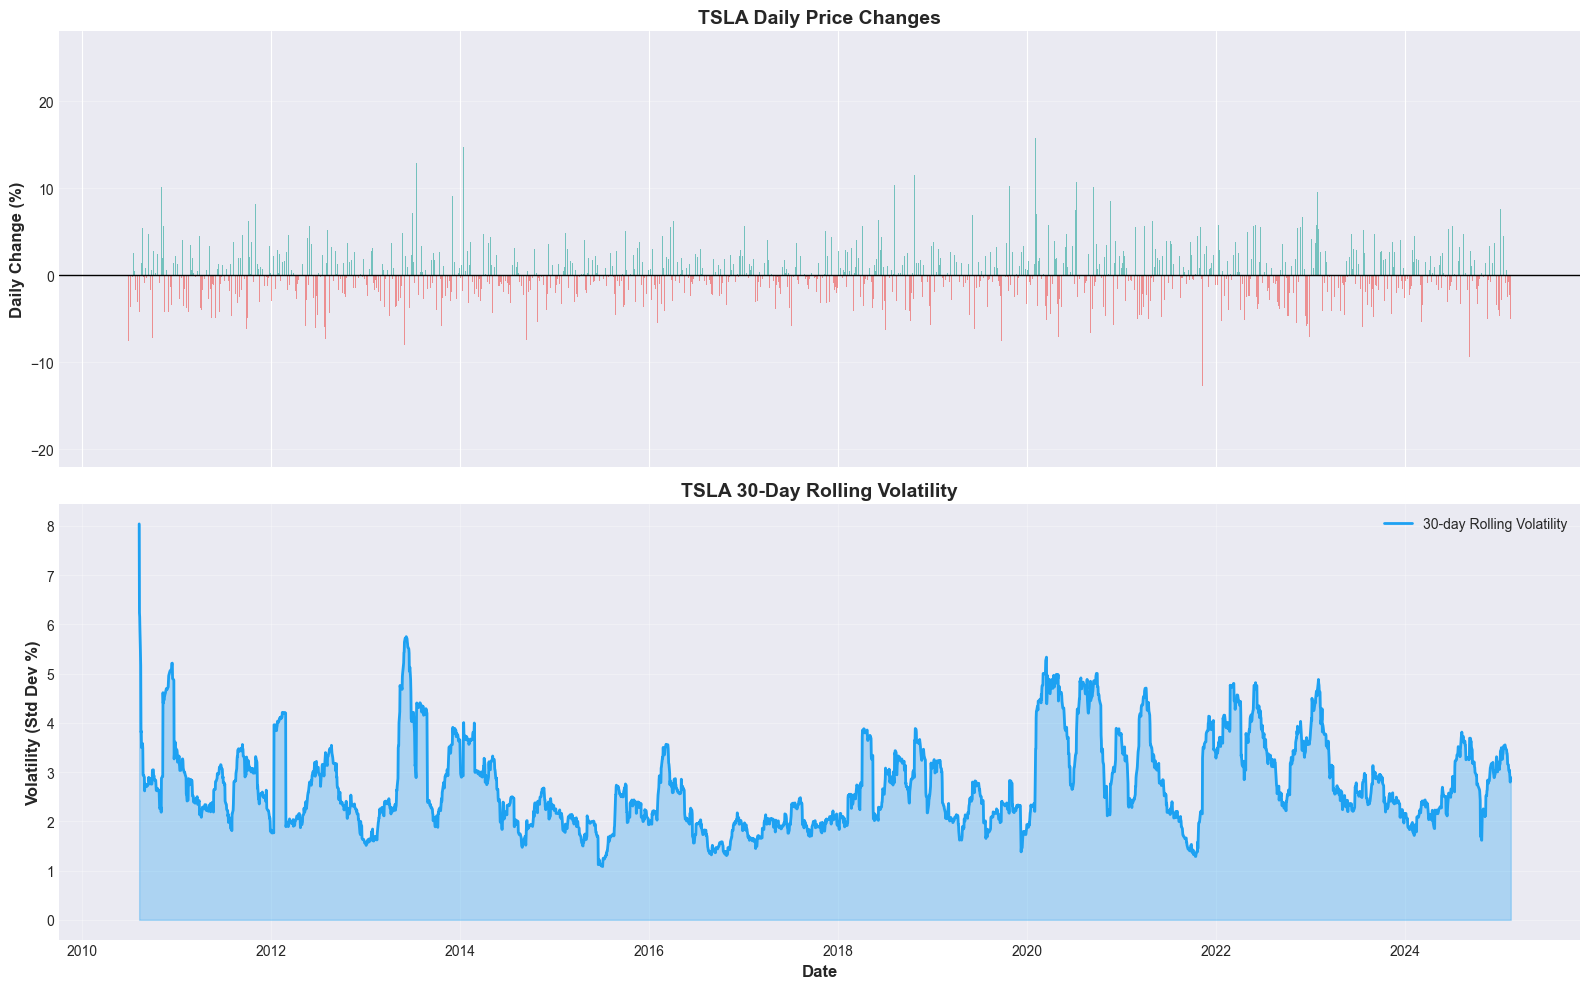

Average 30-day volatility: 2.74%
Median 30-day volatility: 2.50%
Maximum 30-day volatility: 8.04%


In [13]:
# Plot daily percentage changes over time
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Daily percentage change
colors = ['#26A69A' if x >= 0 else '#EF5350' for x in df_tsla['Daily_Change_Pct']]
axes[0].bar(df_tsla['Date'], df_tsla['Daily_Change_Pct'], color=colors, alpha=0.6, width=1)
axes[0].axhline(0, color='black', linewidth=1, linestyle='-')
axes[0].set_ylabel('Daily Change (%)', fontsize=12, fontweight='bold')
axes[0].set_title('TSLA Daily Price Changes', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 30-day rolling volatility (std dev of daily % changes)
df_tsla['Volatility_30d'] = df_tsla['Daily_Change_Pct'].rolling(window=30).std()
axes[1].plot(df_tsla['Date'], df_tsla['Volatility_30d'], 
            color='#1DA1F2', linewidth=2, label='30-day Rolling Volatility')
axes[1].fill_between(df_tsla['Date'], df_tsla['Volatility_30d'], 
                     alpha=0.3, color='#1DA1F2')
axes[1].set_ylabel('Volatility (Std Dev %)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_title('TSLA 30-Day Rolling Volatility', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Average 30-day volatility: {df_tsla['Volatility_30d'].mean():.2f}%")
print(f"Median 30-day volatility: {df_tsla['Volatility_30d'].median():.2f}%")
print(f"Maximum 30-day volatility: {df_tsla['Volatility_30d'].max():.2f}%")